# CNN ResNet Build

# 1. Library Import

In [1]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import SimpleITK as sitk
import json
from skimage import morphology
from skimage import measure

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

# 2. Dataset

## 2.1 Sample 2D

In [2]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [3]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:1000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(1000, 32, 32, 1) (500, 32, 32, 1)


In [4]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:1000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(1000, 10) (500, 10)


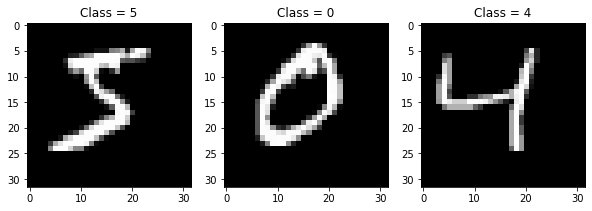

In [5]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

## 2.2 Sample 3D

In [ ]:
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
for i in range(600):
    zero = np.zeros(shape=(32,32,32))
    ones = np.ones(shape=(16,16,16))
    ran = int(np.random.randint(10, size=1)-5)
    if 0 <= i < 200:
        zero[:,:,:] = (ran*10) + 150
        x_train_list.append(zero)
        y_train_list.append([1,0,0])
    elif 200 <= i < 400:
        zero[8+ran:24+ran,8+ran:24+ran,8+ran:24+ran] = (ran*10) + 200
        x_train_list.append(zero)
        y_train_list.append([0,1,0])
    elif 400 <= i < 600:
        for j in range(32):
            for k in range(32):
                for l in range(32):
                    if ((j-16+ran)**2) + ((k-16+ran)**2) + ((l-16+ran)**2) < 100:
                        zero[j,k,l] = (ran*10) + 200
        x_train_list.append(zero)
        y_train_list.append([0,0,1])

for i in range(300):
    zero = np.zeros(shape=(32,32,32))
    ones = np.ones(shape=(16,16,16))
    ran = int(np.random.randint(10, size=1)-5)
    if 0 <= i < 100:
        zero[:,:,:] = (ran*10) + 150
        x_test_list.append(zero)
        y_test_list.append([1,0,0])
    elif 100 <= i < 200:
        zero[8+ran:24+ran,8+ran:24+ran,8+ran:24+ran] = (ran*10) + 200
        x_test_list.append(zero)
        y_test_list.append([0,1,0])
    elif 200 <= i < 300:
        for j in range(32):
            for k in range(32):
                for l in range(32):
                    if ((j-16+ran)**2) + ((k-16+ran)**2) + ((l-16+ran)**2) < 100:
                        zero[j,k,l] = (ran*10) + 200
        x_test_list.append(zero)
        y_test_list.append([0,0,1])

x3_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x3_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
y3_train1 = np.array(y_train_list)
y3_test1 = np.array(y_test_list)
print(x3_train1.shape, x3_test1.shape)
print(y3_train1.shape, y3_test1.shape)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, (3*i)+j+1)
        plt.imshow(x3_train1[(i*200)+(j*50)][(8*j)+8,...,0], cmap='gray')
        plt.title('Class = {}'.format(str(y3_train1[(i*200)+(j*50)])))

# 3. Model Build

## 3.1 Keras Application

In [6]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## 3.2 Block

In [60]:
class ResNetBlock2D:
    def conv1_block(self, lr_conv):
        # layer blcok
        lr_conv = layers.ZeroPadding2D(3)(lr_conv)
        lr_conv = layers.Conv2D(64, 7, 2, activation=None,
                                    padding='valid', kernel_initializer='he_normal')(lr_conv)
        lr_conv = layers.BatchNormalization(axis=-1)(lr_conv)
        lr_conv = layers.Activation('relu')(lr_conv)
        lr_conv = layers.ZeroPadding2D(1)(lr_conv)
        lr_conv = layers.MaxPool2D(3, 2, padding='valid')(lr_conv)
        return lr_conv
    def res_conv_block(self, lr_io, ker_size, block_num, reg_weight, act_func, mode=None):
        for i in range(block_num):
            if mode == 'hold':
                fstr = 1
            else:
                fstr = 2
            # layer block
            if i == 0:
                lr_conv1 = layers.Conv2D(ker_size, 1, fstr, padding='same', kernel_initializer='he_normal', 
                                         kernel_regularizer=regularizers.l2(reg_weight))(lr_io)
            else:
                lr_conv1 = layers.Conv2D(ker_size, 1, 1, padding='same', kernel_initializer='he_normal', 
                                         kernel_regularizer=regularizers.l2(reg_weight))(lr_io)
            lr_conv1 = layers.BatchNormalization(axis=-1)(lr_conv1)
            lr_conv1 = layers.Activation(act_func)(lr_conv1)
            lr_conv2 = layers.Conv2D(ker_size, 3, 1, padding='same', kernel_initializer='he_normal', 
                                         kernel_regularizer=regularizers.l2(reg_weight))(lr_conv1)
            lr_conv2 = layers.BatchNormalization(axis=-1)(lr_conv2)
            lr_conv2 = layers.Activation(act_func)(lr_conv2)
            lr_conv3 = layers.Conv2D(4*ker_size, 1, 1, padding='same', kernel_initializer='he_normal', 
                                         kernel_regularizer=regularizers.l2(reg_weight))(lr_conv2)
            lr_conv3 = layers.BatchNormalization(axis=-1)(lr_conv3)
            if i == 0:
                lr_conv0 = layers.Conv2D(4*ker_size, 1, fstr, padding='same', kernel_initializer='he_normal', 
                                         kernel_regularizer=regularizers.l2(reg_weight))(lr_io)
                lr_conv0 = layers.BatchNormalization(axis=-1)(lr_conv0)
                lr_add = layers.Add()([lr_conv0, lr_conv3])
            else:
                lr_add = layers.Add()([lr_io, lr_conv3])
            lr_io = layers.Activation(act_func)(lr_add)
        return lr_io
    def dense_block(self, lr_dense, block_num, flat_count, reg_weight, act_func, drop_rate):
        lr_dense = layers.Flatten()(lr_dense)
        for i in range(block_num):
            lr_dense = layers.Dense(flat_count, kernel_regularizer=regularizers.l2(reg_weight), 
                                    activation=act_func)(lr_dense)
            lr_dense = layers.Dropout(drop_rate)(lr_dense)
        return lr_dense
        

rb = ResNetBlock2D()

## 3.3 ResNet50

In [66]:
def ResNet50_2D(input_size, channel_num, par_dic):
    # parameters
    reg_weight = par_dic['reg_weight']
    act_func = par_dic['act_func']
    dens_num = par_dic['dens_num']
    flat_count = par_dic['flat_count']
    drop_rate = par_dic['drop_rate']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']
    # code block
    inputs = layers.Input(shape=(input_size, input_size, channel_num))
    conv1 = rb.conv1_block(inputs) # Blcok1
    conv2 = rb.res_conv_block(conv1, 64, 3, reg_weight, act_func, mode='hold') # Block2
    conv3 = rb.res_conv_block(conv2, 128, 4, reg_weight, act_func) # Block3
    conv4 = rb.res_conv_block(conv3, 256, 6, reg_weight, act_func) # Block4
    conv5 = rb.res_conv_block(conv4, 512, 3, reg_weight, act_func) # Block5
    dens = rb.dense_block(conv5, dens_num, flat_count, reg_weight, act_func, drop_rate)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

resnet_param = {'reg_weight': 0.001,
               'act_func': 'relu',
               'dens_num': 1,
               'flat_count': 1024,
               'drop_rate': 0.5,
               'output_count': 10,
               'output_act': 'softmax'}
model = ResNet50_2D(32, 3, resnet_param)
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_70 (ZeroPadding2 (None, 38, 38, 3)    0           input_38[0][0]                   
__________________________________________________________________________________________________
conv2d_945 (Conv2D)             (None, 16, 16, 64)   9472        zero_padding2d_70[0][0]          
__________________________________________________________________________________________________
batch_normalization_945 (BatchN (None, 16, 16, 64)   256         conv2d_945[0][0]                 
___________________________________________________________________________________________

In [69]:
def ResNet101_2D(input_size, channel_num, par_dic):
    # parameters
    reg_weight = par_dic['reg_weight']
    act_func = par_dic['act_func']
    dens_num = par_dic['dens_num']
    flat_count = par_dic['flat_count']
    drop_rate = par_dic['drop_rate']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']
    # code block
    inputs = layers.Input(shape=(input_size, input_size, channel_num))
    conv1 = rb.conv1_block(inputs) # Blcok1
    conv2 = rb.res_conv_block(conv1, 64, 3, reg_weight, act_func, mode='hold') # Block2
    conv3 = rb.res_conv_block(conv2, 128, 4, reg_weight, act_func) # Block3
    conv4 = rb.res_conv_block(conv3, 256, 23, reg_weight, act_func) # Block4
    conv5 = rb.res_conv_block(conv4, 512, 3, reg_weight, act_func) # Block5
    dens = rb.dense_block(conv5, dens_num, flat_count, reg_weight, act_func, drop_rate)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

resnet_param = {'reg_weight': 0.001,
               'act_func': 'relu',
               'dens_num': 2,
               'flat_count': 1000,
               'drop_rate': 0.5,
               'output_count': 10,
               'output_act': 'softmax'}
model = ResNet101_2D(32, 3, resnet_param)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_76 (ZeroPadding2 (None, 38, 38, 3)    0           input_41[0][0]                   
__________________________________________________________________________________________________
conv2d_1104 (Conv2D)            (None, 16, 16, 64)   9472        zero_padding2d_76[0][0]          
__________________________________________________________________________________________________
batch_normalization_1104 (Batch (None, 16, 16, 64)   256         conv2d_1104[0][0]                
___________________________________________________________________________________________

In [70]:
def ResNet152_2D(input_size, channel_num, par_dic):
    # parameters
    reg_weight = par_dic['reg_weight']
    act_func = par_dic['act_func']
    dens_num = par_dic['dens_num']
    flat_count = par_dic['flat_count']
    drop_rate = par_dic['drop_rate']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']
    # code block
    inputs = layers.Input(shape=(input_size, input_size, channel_num))
    conv1 = rb.conv1_block(inputs) # Blcok1
    conv2 = rb.res_conv_block(conv1, 64, 3, reg_weight, act_func, mode='hold') # Block2
    conv3 = rb.res_conv_block(conv2, 128, 8, reg_weight, act_func) # Block3
    conv4 = rb.res_conv_block(conv3, 256, 36, reg_weight, act_func) # Block4
    conv5 = rb.res_conv_block(conv4, 512, 3, reg_weight, act_func) # Block5
    dens = rb.dense_block(conv5, dens_num, flat_count, reg_weight, act_func, drop_rate)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

resnet_param = {'reg_weight': 0.001,
               'act_func': 'relu',
               'dens_num': 2,
               'flat_count': 1000,
               'drop_rate': 0.5,
               'output_count': 10,
               'output_act': 'softmax'}
model = ResNet152_2D(32, 3, resnet_param)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_78 (ZeroPadding2 (None, 38, 38, 3)    0           input_42[0][0]                   
__________________________________________________________________________________________________
conv2d_1208 (Conv2D)            (None, 16, 16, 64)   9472        zero_padding2d_78[0][0]          
__________________________________________________________________________________________________
batch_normalization_1208 (Batch (None, 16, 16, 64)   256         conv2d_1208[0][0]                
___________________________________________________________________________________________